### Machine Learning using Regression models

### Date: May 30, 2025

### Author: Hincal Topcuoglu, Ph.D.

### In this notebook, we continue with regression models with another algorithm named "Random Forest". We will use again "insurance" dataset.We will learn how to interpret model output and generate predictions. We will also look at model performance statistics and compare models. We will use model results to engage in additional feature engineering and selection.


----

Random Forest Regression: Brief Overview

Random Forest is an ensemble machine learning algorithm that builds many decision trees and combines their predictions.

For regression, each tree predicts a numeric value, and the final prediction is the average of all tree predictions.

Each tree is trained on a random subset of the data (using bootstrapping) and considers a random subset of features at each split, which helps reduce overfitting and increases model robustness.

Random Forests can capture complex, nonlinear relationships and interactions between features without requiring explicit feature engineering.

---

Statistical Assumptions of Random Forest Regression

Random Forest regression has very few strict statistical assumptions. Unlike linear regression, it does not require:

The target variable or residuals to be normally distributed.

Homoscedasticity (constant variance of errors).

Linearity between features and target.

Independence of features (it can handle correlated features, though too much correlation can reduce interpretability).

The main “assumptions” are:

The training data is representative of the data you want to predict.

There is some signal in the features that can be used to predict the target (i.e., the problem is not pure noise).

----

What does "ensemble" mean?
In machine learning, an ensemble is a group of models whose individual predictions are combined (by averaging, voting, etc.) to produce a final result.

The goal is to leverage the strengths of each model and reduce their individual weaknesses (such as overfitting or bias).


In Random Forest:

The "forest" is an ensemble of many decision trees.

Each tree is trained on a different random subset of the data and features.

For regression, the final prediction is the average of all tree predictions.

For classification, the final prediction is the majority vote among the trees.


Why use an ensemble?

Reduces overfitting: Individual trees may overfit, but averaging their predictions smooths out errors.

Improves accuracy and robustness: The combined model is usually more accurate and stable than any single tree.


In summary:

"Ensemble" in Random Forest means using a collection of decision trees together, rather than relying on just one, to make better and more reliable predictions.

---

What is Bootstrapping?
Bootstrapping is a statistical technique that involves randomly sampling data with replacement to create many new datasets (called “bootstrap samples”) from the original dataset.

How Does Bootstrapping Work?
Suppose you have a dataset with n observations.
You create a new dataset by randomly selecting n observations from the original data, with replacement (so some rows may appear multiple times, and some not at all).
This process is repeated many times to create many bootstrap samples.

Why Use Bootstrapping?
Estimate uncertainty: Bootstrapping allows you to estimate the variability (standard error, confidence intervals) of a statistic (like the mean, median, or model accuracy) without making strong assumptions about the data’s distribution.

Model stability: In machine learning, bootstrapping is used in ensemble methods (like Random Forest) to train each model (tree) on a different random sample, increasing diversity and reducing overfitting.

Bootstrapping in Random Forest

Each decision tree in a Random Forest is trained on a different bootstrap sample of the data.

This means each tree sees a slightly different version of the data, making the ensemble more robust and less likely to overfit.

Key Points

Sampling with replacement means some data points can appear more than once in a sample, while others may not appear at all.

### We start by loading or libraries and functions.

In [39]:
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import statsmodels.api as sm
from sklearn import linear_model
import matplotlib.pyplot as plt
from math import sqrt
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import plot_tree
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

### Load the data and have a first look.

In [2]:
data = pd.read_csv('insurance.csv')

In [3]:
data.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


OK, this is our data. We want to predict insurance expenses for individuals. We want to use the information in our data to make predictions out of sample that are as accurate as possible.

But first, let's get to know our data and see what we have to work with.

How many observations do we have?

In [4]:
len(data)

1338

Get a first set of descriptive statistics for the continuous variables.

What do we see? Missing data? Skewness of distribtution?

In [5]:
data.describe()

,age,bmi,children,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414
std,14.049960,6.098382,1.205493,12110.011240
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.700000,2.000000,16639.915000
max,64.000000,53.100000,5.000000,63770.430000


Missing data for the categorical variables?

In [6]:
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

OK, great, no missing data to worry about.

When you look at the continuous variables, what do you think we should be looking at next?

In [7]:
data.describe()

,age,bmi,children,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414
std,14.049960,6.098382,1.205493,12110.011240
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.700000,2.000000,16639.915000
max,64.000000,53.100000,5.000000,63770.430000


Hincal comment : There is no need for now to normalize continous variables, firstly we should understand what is the regression model does with these variables

Hincal comment: lets look at distributions of data

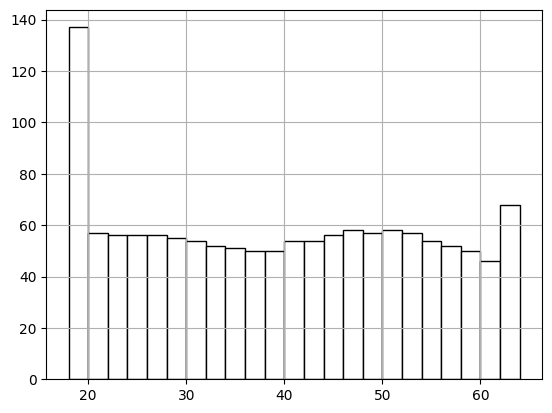

In [8]:
data.age.hist(bins=np.arange(min(data.age), max(data.age) + 2,2),
                                   range=[0,70],color="white",edgecolor="black")

plt.show()

Hincal comment: in age variable there is no variability except for age 0-20

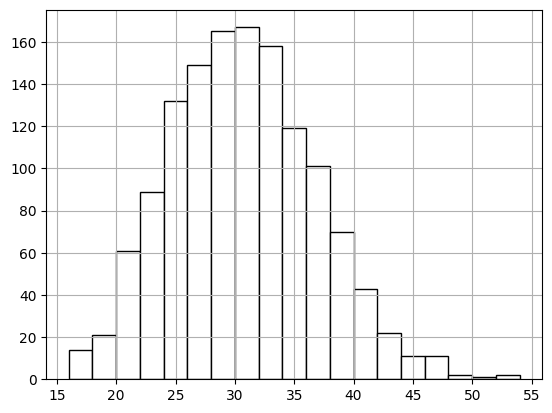

In [9]:
data.bmi.hist(bins=np.arange(min(data.bmi), max(data.bmi) + 2,2),
                                   range=[0,60],color="white",edgecolor="black")

plt.show()

Hincal comment: in age variable there is no variability except for age 0-20

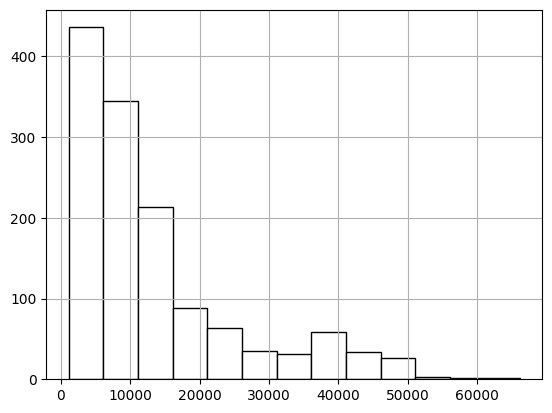

In [11]:
data.expenses.hist(bins=np.arange(min(data.expenses), max(data.expenses) + 5000,5000),
                                   range=[0,65000],color="white",edgecolor="black")

plt.show()

Hincal comment: target variable expenses have positive skewed data. we can make a log transformation to make it normally distributed. We do it because, Linear Regression models theoretically assumes that errors and so by target variable should have normal distribution

Hincal comment: Since Random forest model does not require strict assumptions like linear regression, I will make transformations on target variable to check if predictios are better

In [14]:
data['log_expenses'] = np.log(data['expenses'])
data['sqrt_expenses'] = np.sqrt(data['expenses'])

# Log transformation (add 1 if there are zeros to avoid log(0))
data['expenses_log'] = np.log(data['expenses'] + 1)

# Square root transformation
data['expenses_sqrt'] = np.sqrt(data['expenses'])

# Box-Cox transformation (data must be strictly positive)
# If there are zeros or negatives, you need to shift the data
expenses_positive = data['expenses'] + 1 if (data['expenses'] <= 0).any() else data['expenses']
data['expenses_boxcox'], fitted_lambda = boxcox(expenses_positive)

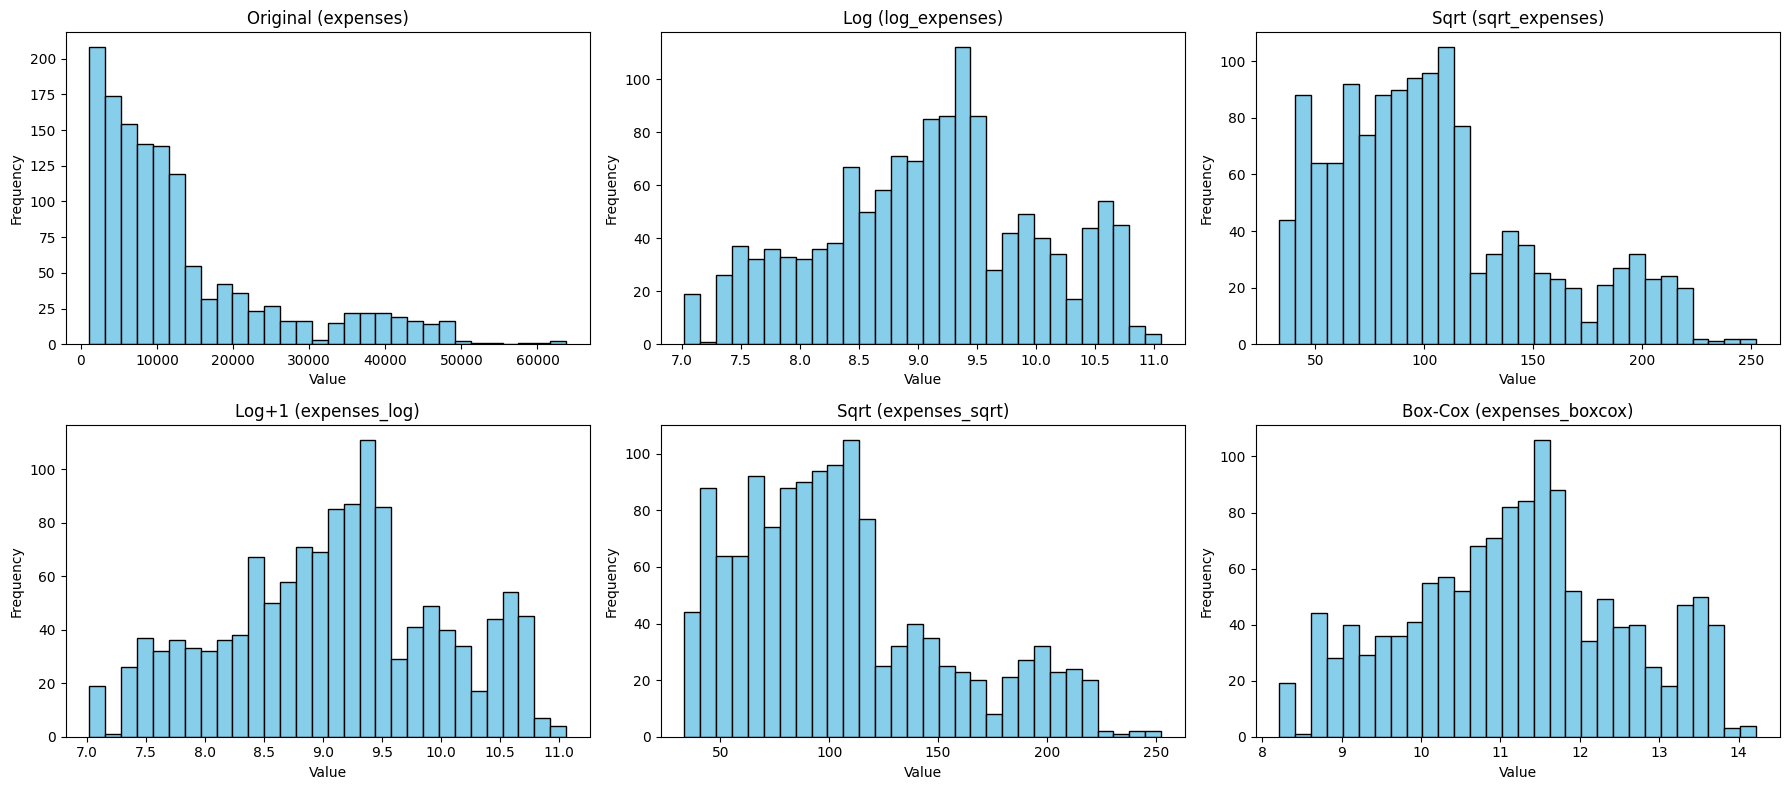

In [15]:
# lets plot all target variables

# List of target columns to plot
target_cols = [
    'expenses',
    'log_expenses',
    'sqrt_expenses',
    'expenses_log',
    'expenses_sqrt',
    'expenses_boxcox'
]
titles = [
    'Original (expenses)',
    'Log (log_expenses)',
    'Sqrt (sqrt_expenses)',
    'Log+1 (expenses_log)',
    'Sqrt (expenses_sqrt)',
    'Box-Cox (expenses_boxcox)'
]

plt.figure(figsize=(18, 8))

for i, (col, title) in enumerate(zip(target_cols, titles), 1):
    plt.subplot(2, 3, i)
    plt.hist(data[col], bins=30, color='skyblue', edgecolor='black')
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [16]:
# check data
data.head()

,age,sex,bmi,children,smoker,region,expenses,log_expenses,sqrt_expenses,expenses_log,expenses_sqrt,expenses_boxcox
0,19,female,27.9,0,yes,southwest,16884.92,9.734176,129.941987,9.734235,129.941987,12.128977
1,18,male,33.8,1,no,southeast,1725.55,7.453301,41.539740,7.453880,41.539740,8.808593
2,28,male,33.0,3,no,southeast,4449.46,8.400538,66.704273,8.400763,66.704273,10.147519
3,33,male,22.7,0,no,northwest,21984.47,9.998092,148.271609,9.998137,148.271609,12.534948
4,32,male,28.9,0,no,northwest,3866.86,8.260198,62.184082,8.260457,62.184082,9.945637


Hincal comment: since random forest has not a linear regression like assumption, there is no need to check if target variables distributed normally, I created it to model with different target variables if there is increase in predictive power of the model

Hincal Comment: You do not need to check a correlation graph before applying a Random Forest model, but it can still be useful for understanding your data.

Why?
Random Forests are not sensitive to multicollinearity (high correlation between features) the way linear regression is. 

They can handle correlated features without the risk of unstable coefficients or inflated variance.

Random Forests automatically select and weight features during the tree-building process, so redundant or correlated features are less of a problem.

Hincal Comment: Lets plot correlation heatmap even so understand the data

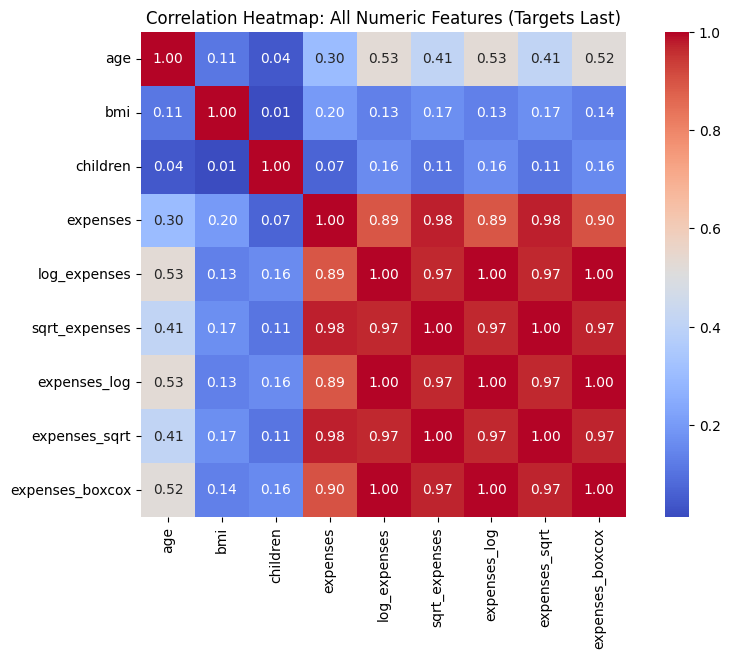

In [19]:
# List of target columns in your desired order
target_cols = [
    'expenses',
    'log_expenses',
    'sqrt_expenses',
    'expenses_log',
    'expenses_sqrt',
    'expenses_boxcox'
]

# Get all numeric columns
numeric_cols = data.select_dtypes(include='number').columns.tolist()

# Remove target columns from the list if they are present
main_cols = [col for col in numeric_cols if col not in target_cols]

# Create the final column order: all other numeric columns, then your targets in order
final_cols = main_cols + target_cols

# Compute the correlation matrix for these columns
corr_matrix = data[final_cols].corr()

# Reorder the correlation matrix
corr_matrix = corr_matrix.loc[final_cols, final_cols]

# Plot the heatmap
plt.figure(figsize=(max(10, len(final_cols) * 0.7), 0.7 * len(final_cols)))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True,
            xticklabels=final_cols, yticklabels=final_cols)
plt.title('Correlation Heatmap: All Numeric Features (Targets Last)')
plt.show()

Hincal Comment: Lets look Cramer's V correlation. it means that we will look at correlation between our categorical varibles with target variable. It is not essential, just purpose of learning new thing

In [21]:
data['expenses_bin'] = pd.qcut(data['expenses'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

cat_cols = ['sex', 'smoker', 'region']  # Add more if you have them

for col in cat_cols:
    v = cramers_v(data[col], data['expenses_bin'])
    print(f"Cramér's V between {col} and binned expenses: {v:.2f}")

Cramér's V between sex and binned expenses: 0.07
Cramér's V between smoker and binned expenses: 0.80
Cramér's V between region and binned expenses: 0.05


Hincal comment: As remember from our linear regression model results, smoker variable is important again

Hincal Comment: We do not need to transform any of our variables when applying RF model

Why?

Random Forests are tree-based models that split data based on thresholds, not on the distribution of the variables.

They are invariant to monotonic transformations of the features. This means that whether you use the original, log-transformed, or Box-Cox-transformed version of a continuous variable, the splits and model performance will be nearly the same.

Random Forests handle skewed, non-normal, and even categorical data (with encoding) very well.

---

Hincal Comment: Lets make some feature engineering to check if they are important for model and make an impact on models performance.

Feature Engineering Ideas for Insurance Data


1. Interaction Features

age_bmi: Interaction between age and BMI.

bmi_smoker: BMI multiplied by smoker status (captures the amplified risk for smokers with high BMI).

age_smoker: Age multiplied by smoker status.


2. Polynomial Features


bmi_squared: BMI squared (captures nonlinear effects).

age_squared: Age squared.

3. Binning/Grouping

age_group: Bin age into categories (e.g., <30, 30–50, >50).

bmi_category: Bin BMI into underweight, normal, overweight, obese.

4. Count/Ratio Features

has_children: Binary indicator for having children.

bmi_per_child: BMI divided by (children + 1) to avoid division by zero.

5. Combined Categorical Features

region_smoker: Combine region and smoker status to capture regional smoking effects.

In [23]:
# Interaction features
data['age_bmi'] = data['age'] * data['bmi']
data['bmi_smoker'] = data['bmi'] * (data['smoker'] == 'yes').astype(int)
data['age_smoker'] = data['age'] * (data['smoker'] == 'yes').astype(int)

# Polynomial features
data['bmi_squared'] = data['bmi'] ** 2
data['age_squared'] = data['age'] ** 2

# Binning
data['age_group'] = pd.cut(data['age'], bins=[0, 30, 50, 100], labels=['<30', '30-50', '>50'])
data['bmi_category'] = pd.cut(data['bmi'], bins=[0, 18.5, 25, 30, 100], labels=['underweight', 'normal', 'overweight', 'obese'])

# Count/ratio
data['has_children'] = (data['children'] > 0).astype(int)
data['bmi_per_child'] = data['bmi'] / (data['children'] + 1)

# Combined categorical
data['region_smoker'] = data['region'] + '_' + data['smoker']

In [24]:
data.head()

,age,sex,bmi,children,smoker,region,expenses,log_expenses,sqrt_expenses,expenses_log,...,age_bmi,bmi_smoker,age_smoker,bmi_squared,age_squared,age_group,bmi_category,has_children,bmi_per_child,region_smoker
0,19,female,27.9,0,yes,southwest,16884.92,9.734176,129.941987,9.734235,...,530.1,27.9,19,778.41,361,<30,overweight,0,27.90,southwest_yes
1,18,male,33.8,1,no,southeast,1725.55,7.453301,41.539740,7.453880,...,608.4,0.0,0,1142.44,324,<30,obese,1,16.90,southeast_no
2,28,male,33.0,3,no,southeast,4449.46,8.400538,66.704273,8.400763,...,924.0,0.0,0,1089.00,784,<30,obese,1,8.25,southeast_no
3,33,male,22.7,0,no,northwest,21984.47,9.998092,148.271609,9.998137,...,749.1,0.0,0,515.29,1089,30-50,normal,0,22.70,northwest_no
4,32,male,28.9,0,no,northwest,3866.86,8.260198,62.184082,8.260457,...,924.8,0.0,0,835.21,1024,30-50,overweight,0,28.90,northwest_no


#### Now, let's set estimate a random forest for regression problem - baseline model with all predictor features

In [26]:
# List of continuous features (add your engineered continuous features here)
continuous_features = [
    'age', 'bmi', 'children', 'age_bmi', 'bmi_smoker', 'age_smoker',
    'bmi_squared', 'age_squared', 'bmi_per_child'
]

# List of categorical features (add your engineered categorical features here)
categorical_features = [
    'sex', 'smoker', 'region', 'age_group', 'bmi_category', 'region_smoker'
]

# Combine all features
all_features = continuous_features + categorical_features

# One-hot encode categorical features
X = pd.get_dummies(data[all_features], drop_first=True)

# Use the original target or a transformed one
y = data['expenses']  # or 'expenses_boxcox', etc.

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Random Forest Regressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Predict
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Evaluate
metrics = {
    'Train R2': r2_score(y_train, y_train_pred),
    'Test R2': r2_score(y_test, y_test_pred),
    'Train MSE': mean_squared_error(y_train, y_train_pred),
    'Test MSE': mean_squared_error(y_test, y_test_pred),
    'Train MAE': mean_absolute_error(y_train, y_train_pred),
    'Test MAE': mean_absolute_error(y_test, y_test_pred)
}

print(metrics)

{'Train R2': 0.9735822202492808, 'Test R2': 0.8673377062087441, 'Train MSE': 3812973.8227934972, 'Test MSE': 20595653.124413375, 'Train MAE': 1070.288535732087, 'Test MAE': 2487.0962051119404}


Hincal Comment: There is an overit of the model. It learned a lot of train dataset.
    
Train R²: 0.97 (very high, almost perfect fit)

Test R²: 0.87 (good, but much lower than train)

Train MAE: 1,070 vs. Test MAE: 2,487 (test error is much higher)

Train MSE: much lower than Test MSE

Why is this happening?

Random Forests can overfit if the number of trees is high and/or the trees are very deep (default settings often allow trees to grow very deep).

Too many features (especially with one-hot encoding) can also increase the risk of overfitting, as the model can memorize the training data.

---

Hincal Comment: In first step to avoid overfitting it is better to reduce number of features given into model, so lets check baseline model feature importance

                        Feature  Importance
4                    bmi_smoker    0.747870
3                       age_bmi    0.053998
7                   age_squared    0.052148
0                           age    0.046170
8                 bmi_per_child    0.034525
5                    age_smoker    0.012845
1                           bmi    0.012606
6                   bmi_squared    0.010669
2                      children    0.006630
10                   smoker_yes    0.003448
9                      sex_male    0.003249
17      bmi_category_overweight    0.002758
12             region_southeast    0.001912
11             region_northwest    0.001799
20   region_smoker_northwest_no    0.001552
13             region_southwest    0.001500
22   region_smoker_southeast_no    0.001450
24   region_smoker_southwest_no    0.001382
18           bmi_category_obese    0.001089
16          bmi_category_normal    0.000833
14              age_group_30-50    0.000515
19  region_smoker_northeast_yes 

<Figure size 800x600 with 0 Axes>

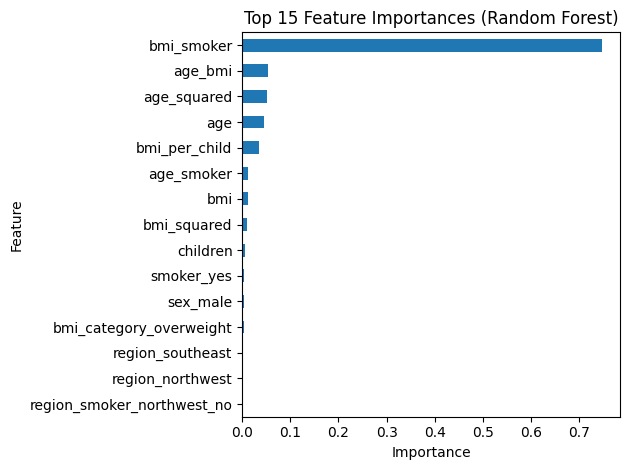

In [27]:
importances = rf.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for easy viewing and sorting
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_imp_df)

# Plot the top 15 most important features
plt.figure(figsize=(8, 6))
feat_imp_df.head(15).plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.gca().invert_yaxis()
plt.title('Top 15 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Hincal Comment: Lets retrain model with most important features

In [28]:
top_features = [
    'bmi_smoker', 'age_bmi', 'age_squared', 'bmi_per_child',
    'age_smoker', 'bmi'
]

X_top = X[top_features]

# Train-test split
X_train_top, X_test_top, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=42)

# Fit Random Forest
rf_top = RandomForestRegressor(random_state=42)
rf_top.fit(X_train_top, y_train)

# Predict and evaluate
y_train_pred = rf_top.predict(X_train_top)
y_test_pred = rf_top.predict(X_test_top)

metrics = {
    'Train R2': r2_score(y_train, y_train_pred),
    'Test R2': r2_score(y_test, y_test_pred),
    'Train MSE': mean_squared_error(y_train, y_train_pred),
    'Test MSE': mean_squared_error(y_test, y_test_pred),
    'Train MAE': mean_absolute_error(y_train, y_train_pred),
    'Test MAE': mean_absolute_error(y_test, y_test_pred)
}

print(metrics)

{'Train R2': 0.972781421196397, 'Test R2': 0.8624328561006016, 'Train MSE': 3928556.050171271, 'Test MSE': 21357124.89282329, 'Train MAE': 1061.6119593052958, 'Test MAE': 2460.5433179317697}


Hincal Comment:
Interpretation

Overfitting is still present: The gap between train and test R² and errors remains large, though slightly reduced.

Model performance on test data is still strong (R² = 0.86), but the model fits the training data almost perfectly, which is a sign of overfitting.

Reducing features helped a bit, but Random Forests can still overfit if trees are too deep or leaves are too small.

---

Hincal Comment: Let's play with hyper parameters, we will make a grid search

In [31]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_leaf': [1, 5, 10, 20],
    'max_features': ['sqrt', 'log2', None]
}

# Initialize the model
rf = RandomForestRegressor(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',
    n_jobs=-1,  # Use all available cores
    verbose=2
)

# Fit the grid search to the reduced feature set
grid_search.fit(X_train_top, y_train)

# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best CV score (neg MSE):", grid_search.best_score_)

# Evaluate on test set
best_rf = grid_search.best_estimator_
y_test_pred = best_rf.predict(X_test_top)

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

metrics = {
    'Test R2': r2_score(y_test, y_test_pred),
    'Test MSE': mean_squared_error(y_test, y_test_pred),
    'Test MAE': mean_absolute_error(y_test, y_test_pred)
}
print(metrics)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 200}
Best CV score (neg MSE): -21083602.121568047
{'Test R2': 0.8768737333963829, 'Test MSE': 19115196.978746086, 'Test MAE': 2594.899065897088}
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, n_estimators=200; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=20, n_estimators=200; total time=   0.2s
[CV] E

---

Hincal comment: Lets retrain model with best hyperparameters

In [32]:
# Use the best parameters from GridSearchCV
best_rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=5,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42
)

# Fit the model on the reduced feature set
best_rf.fit(X_train_top, y_train)

# Predict on train and test sets
y_train_pred = best_rf.predict(X_train_top)
y_test_pred = best_rf.predict(X_test_top)

# Evaluate
metrics = {
    'Train R2': r2_score(y_train, y_train_pred),
    'Test R2': r2_score(y_test, y_test_pred),
    'Train MSE': mean_squared_error(y_train, y_train_pred),
    'Test MSE': mean_squared_error(y_test, y_test_pred),
    'Train MAE': mean_absolute_error(y_train, y_train_pred),
    'Test MAE': mean_absolute_error(y_test, y_test_pred)
}

print(metrics)

{'Train R2': 0.8749552426977139, 'Test R2': 0.8768737333963829, 'Train MSE': 18048162.66810621, 'Test MSE': 19115196.978746086, 'Train MAE': 2390.162756420775, 'Test MAE': 2594.899065897088}


Hincal Comment: Great ! we reduced overfitting and have best and robust model now.

Interpretation

Train and test R² are nearly identical—this is a strong indicator that your model generalizes well and is not overfitting.

Train and test errors (MSE, MAE) are also very close, confirming the model’s stability.

Feature selection and hyperparameter tuning have resulted in a robust, interpretable, and high-performing Random Forest regression model.

Hincal Comment: This is a textbook example of how to use feature importance and hyperparameter tuning to control overfitting in tree-based models.

#### Plot the tree structure of one of the estimated trees

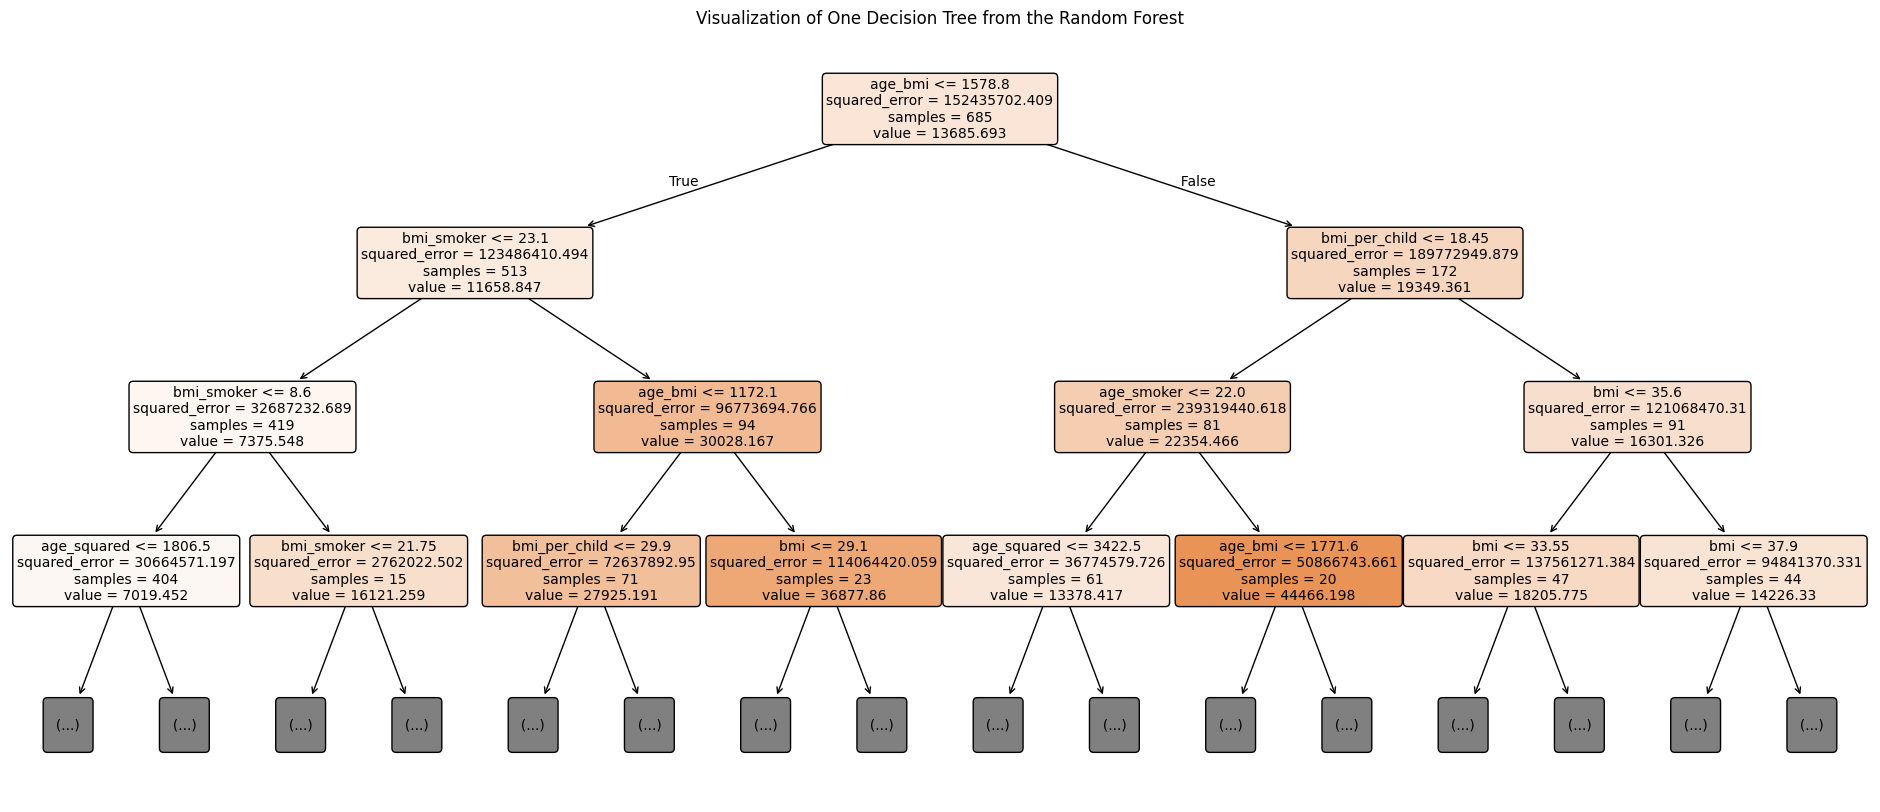

In [35]:
# Select the first tree from the forest
estimator = best_rf.estimators_[0]

plt.figure(figsize=(24, 10))
plot_tree(
    estimator,
    feature_names=X_train_top.columns,
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=3  # Limit depth for readability; adjust as needed
)
plt.title("Visualization of One Decision Tree from the Random Forest")
plt.show()

Hincal Comment:

This plot shows only one tree, not the entire forest. Random Forests average the predictions of all trees, but visualizing one tree is great for teaching and understanding the model’s logic.

Hincal Comment:

Remember from our last Linear Regression Problem which gave results as:

  'Train R2': 0.773017292621986,

  'Test R2': 0.8143770399970309,

  'Train MSE': 0.41625247555278894,
  
  'Test MSE': 0.3687785535211372,
  
  'Train MAE': 0.3941237642042971,
  
  'Test MAE': 0.3821463158097262
 
----

Now Random Forest Model gives results as: 

   'Train R2': 0.8749552426977139, 
   
   'Test R2': 0.8768737333963829, 
   
   'Train MSE': 18048162.66810621, 
   
   'Test MSE': 19115196.978746086, 
   
   'Train MAE': 2390.162756420775, 
   
   'Test MAE': 2594.899065897088

---

Focus on R2 Scores and Train/Test MSE values. Since Linear model run on box-cox transformed target variable, other metric variables except for R2 score seems different but if we make an inverse calculation, we can show them at the same line too. 

Result is: Random Forest with reduced features and best hyperparameters is better than Linear Regression Model. Because it captures non-linearities in model


---

Hincal Comment: Lets make Residual Analysis

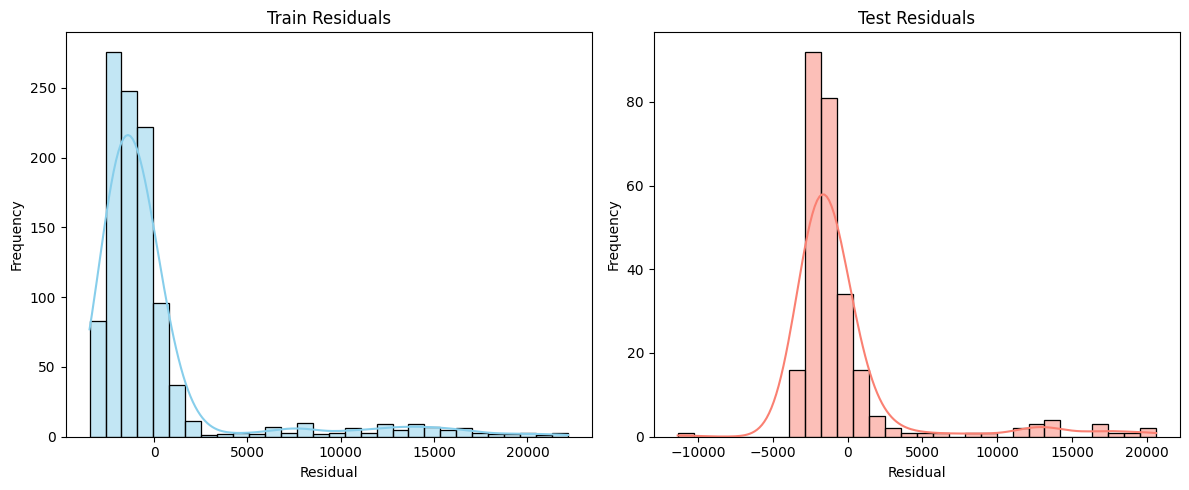

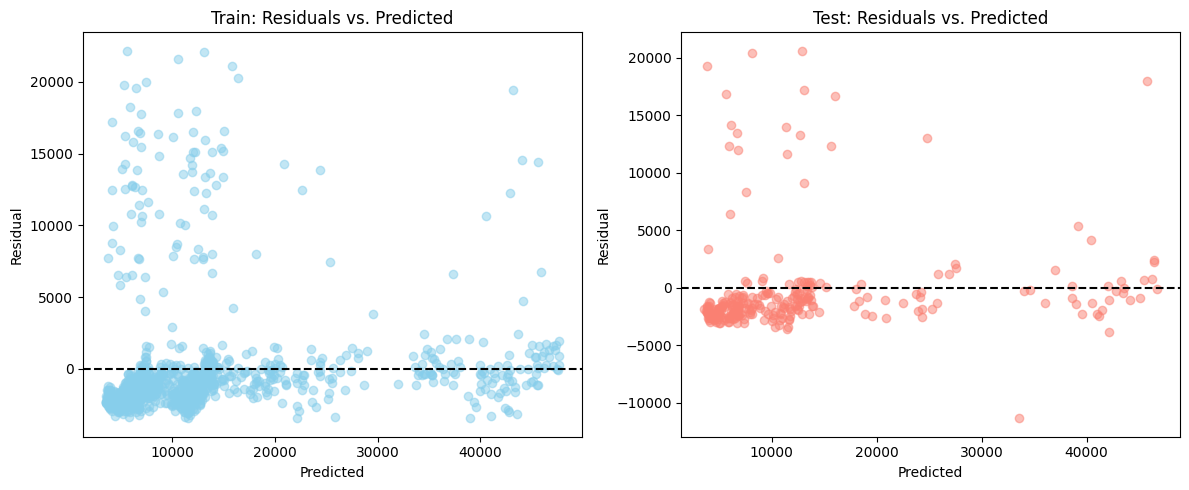

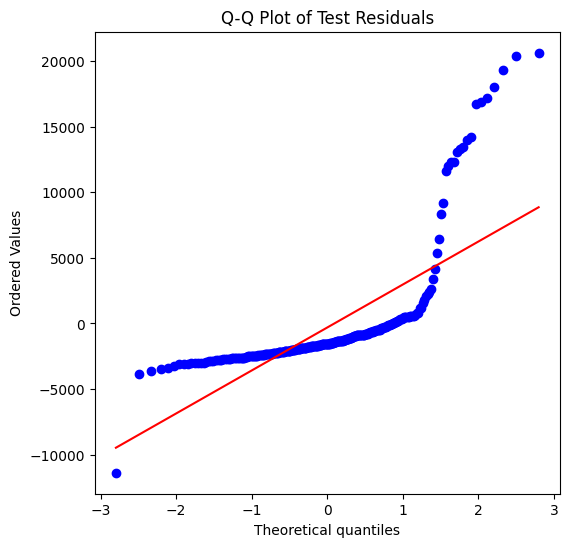

In [41]:
# Calculate residuals
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

# 1. Histogram of residuals
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(train_residuals, bins=30, kde=True, color='skyblue', label='Train')
plt.title('Train Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(test_residuals, bins=30, kde=True, color='salmon', label='Test')
plt.title('Test Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# 2. Residuals vs. Predicted values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_train_pred, train_residuals, alpha=0.5, color='skyblue')
plt.axhline(0, color='black', linestyle='--')
plt.title('Train: Residuals vs. Predicted')
plt.xlabel('Predicted')
plt.ylabel('Residual')

plt.subplot(1, 2, 2)
plt.scatter(y_test_pred, test_residuals, alpha=0.5, color='salmon')
plt.axhline(0, color='black', linestyle='--')
plt.title('Test: Residuals vs. Predicted')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.tight_layout()
plt.show()

# 3. Q-Q plot for test residuals (normality check)

plt.figure(figsize=(6, 6))
stats.probplot(test_residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Test Residuals')
plt.show()

---

Hincal Comment: 

Lastly lets create a scatter graph between predictions and actuals

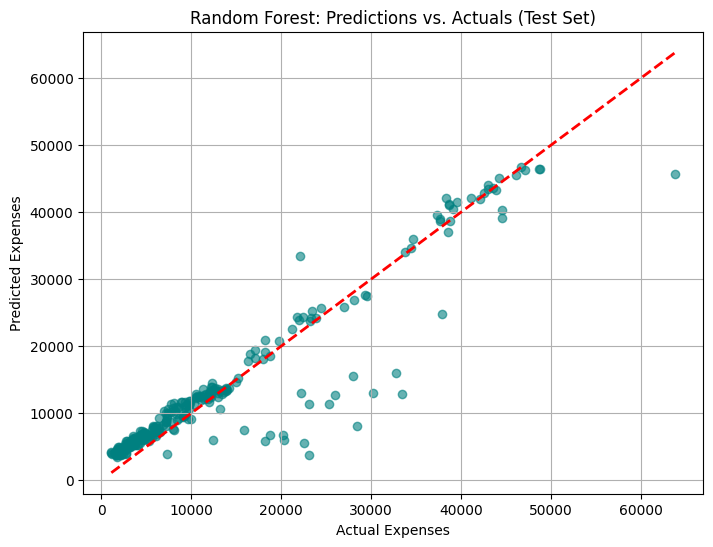

In [42]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Diagonal line
plt.xlabel('Actual Expenses')
plt.ylabel('Predicted Expenses')
plt.title('Random Forest: Predictions vs. Actuals (Test Set)')
plt.grid(True)

Hincal Comment:

Points close to the red dashed diagonal indicate accurate predictions.

Systematic deviations from the line may indicate bias or model limitations.

A tight, linear cloud around the diagonal is a sign of a well-performing regression model.

This study is done by Hincal Topcuoglu. Thank you